## 1. Setup

In [1]:
import os
import tensorflow as tf

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Avoiding OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 2. Remove dodgy images

In [4]:
import cv2
import imghdr

In [5]:
data_dir = 'Dataset'

In [6]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

## 3. Load Data

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory('Dataset')

Found 532 files belonging to 7 classes.


In [11]:
class_names = data.class_names
class_indices = {class_name: index for index, class_name in enumerate(class_names)}
print("Class Indices:", class_indices)

Class Indices: {'Angry': 0, 'Disgusted': 1, 'Fearful': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprised': 6}


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

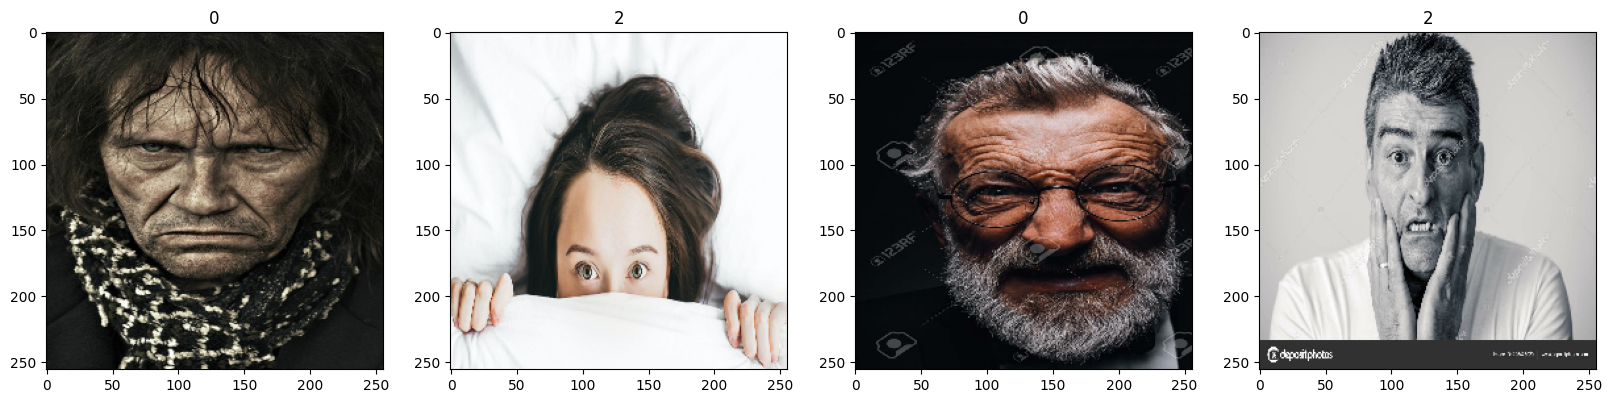

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## 4. Scale Data

In [15]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[5.0816864e-01, 5.2385491e-01, 5.3169805e-01],
          [5.2941179e-01, 5.4509807e-01, 5.4901963e-01],
          [5.0065106e-01, 5.0947839e-01, 5.1568627e-01],
          ...,
          [5.5686277e-01, 5.6666666e-01, 5.7254905e-01],
          [5.5490196e-01, 5.7058823e-01, 5.7450980e-01],
          [5.4869407e-01, 5.6438035e-01, 5.6830192e-01]],
 
         [[5.1079583e-01, 5.2352941e-01, 5.3234148e-01],
          [5.3137255e-01, 5.4705882e-01, 5.5098039e-01],
          [5.1568627e-01, 5.1665521e-01, 5.2745098e-01],
          ...,
          [5.5490965e-01, 5.6764323e-01, 5.7254905e-01],
          [5.4607463e-01, 5.6176090e-01, 5.6371403e-01],
          [5.5294120e-01, 5.6862748e-01, 5.7254905e-01]],
 
         [[5.1143152e-01, 5.2711779e-01, 5.3103936e-01],
          [5.3170574e-01, 5.4739201e-01, 5.5131358e-01],
          [4.8952973e-01, 4.9933365e-01, 5.0521600e-01],
          ...,
          [5.5294120e-01, 5.6862748e-01, 5.7254905e-01],
          [5.5294120e-01, 5.6862748e-

## 5. Split Data

In [17]:
len(data)

17

In [18]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## 6. Build Deep Learning Model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [21]:
model = Sequential()

In [22]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='sigmoid'))

In [23]:
model.compile('adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

## 7. Train Model

In [25]:
logdir='logs'

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [27]:

hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
11/11 [==============================] - 12s 358ms/step - loss: 2.1435 - accuracy: 0.1449 - val_loss: 1.9401 - val_accuracy: 0.1354
Epoch 2/20
11/11 [==============================] - 5s 342ms/step - loss: 1.9092 - accuracy: 0.1989 - val_loss: 1.8970 - val_accuracy: 0.1354
Epoch 3/20
11/11 [==============================] - 5s 339ms/step - loss: 1.8191 - accuracy: 0.2642 - val_loss: 1.7945 - val_accuracy: 0.3646
Epoch 4/20
11/11 [==============================] - 5s 342ms/step - loss: 1.6392 - accuracy: 0.4205 - val_loss: 1.5548 - val_accuracy: 0.4167
Epoch 5/20
11/11 [==============================] - 5s 338ms/step - loss: 1.4363 - accuracy: 0.4943 - val_loss: 1.2794 - val_accuracy: 0.6146
Epoch 6/20
11/11 [==============================] - 5s 347ms/step - loss: 1.1902 - accuracy: 0.6023 - val_loss: 1.2378 - val_accuracy: 0.6354
Epoch 7/20
11/11 [==============================] - 5s 332ms/step - loss: 1.0383 - accuracy: 0.6932 - val_loss: 1.0488 - val_accuracy: 0.6562
Epoch

## 8. Plot Performance

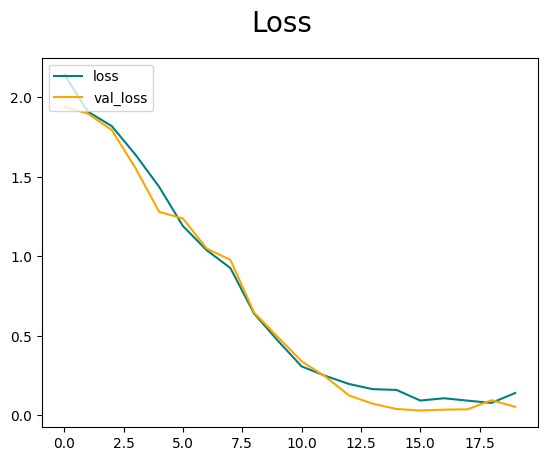

In [28]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

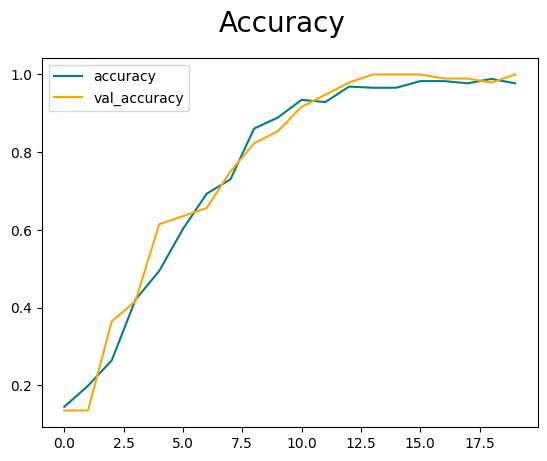

In [29]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## 10. Test

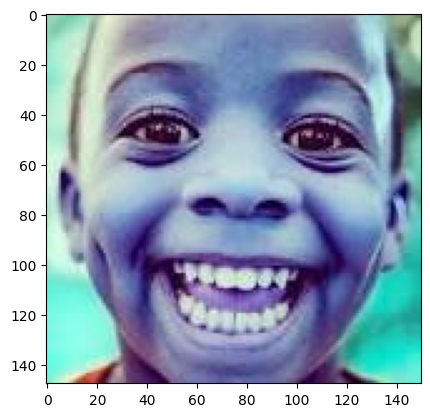

In [34]:
img = cv2.imread('Happy_test.jpeg')
plt.imshow(img)
plt.show()

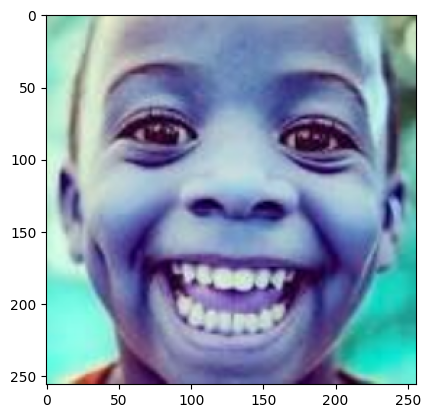

In [35]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [36]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 25ms/step


In [37]:
np.argmax(yhat, axis=-1)

array([3], dtype=int64)

In [38]:
if np.argmax(yhat) == 0:
    print(f'Predicted class is Angry')
elif np.argmax(yhat) == 1:
    print(f'Predicted class is "Disgusted')
elif np.argmax(yhat) == 2:
    print(f'Predicted class is "Fearful')
elif np.argmax(yhat) == 3:
    print(f'Predicted class is "Happy')
elif np.argmax(yhat) == 4:
    print(f'Predicted class is "Neutral')
elif np.argmax(yhat) == 5:
    print(f'Predicted class is "Sad')
elif np.argmax(yhat) == 6:
    print(f'Predicted class is "Surprised')

Predicted class is "Happy


## 11. Save

In [39]:
from tensorflow.keras.models import load_model

In [41]:
model.save(os.path.join('models','EmotionClassifier.h5'))

In [44]:
new_model = load_model('models/EmotionClassifier.h5')

In [46]:
yhat_2 = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 31ms/step


In [47]:
np.argmax(yhat_2, axis=-1)

array([3], dtype=int64)

In [48]:
if np.argmax(yhat) == 0:
    print(f'Predicted class is Angry')
elif np.argmax(yhat) == 1:
    print(f'Predicted class is "Disgusted')
elif np.argmax(yhat) == 2:
    print(f'Predicted class is "Fearful')
elif np.argmax(yhat) == 3:
    print(f'Predicted class is "Happy')
elif np.argmax(yhat) == 4:
    print(f'Predicted class is "Neutral')
elif np.argmax(yhat) == 5:
    print(f'Predicted class is "Sad')
elif np.argmax(yhat) == 6:
    print(f'Predicted class is "Surprised')

Predicted class is "Happy
